This notebook uses Google Cloud AutoML to classify text as either positive, neutral or negative. We ran the sentiment analysis for twitter tweets and facebook posts. Below is a high level overview of the process
<img src="files/automl.png">

We uploaded sentiment-model-6-1 file to Google Cloud and trained a custom NLP model using the training data.

Please refer to the link for documentation about using Google Cloud AutoML.
https://cloud.google.com/natural-language/automl/sentiment/docs/

<img src="files/training.png">

In [8]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

## Training

In [6]:
# Training file that was uploaded to Google Cloud
training = pd.read_csv('./files/SentimentAnalysis/sentiment-model-6-1.csv')
training.head()

,Post,Sentiment
0,I‚Äôm drinking reds apple ale in my room waiti...,2.0
1,Fuck Kodak. Literally the ONLY song I like of ...,0.0
2,@ArianaGrande YO your drink is so good wtf #cloud,2.0
3,@ArianaGrande i was drinking the cloud macchia...,2.0
4,i thought ariana grande was vegan lmfaooo,0.0


Posts that are negative have a sentiment score of 0, posts that are neutral have a sentiment score of 1 and posts that are positive have a sentiment score of 2.

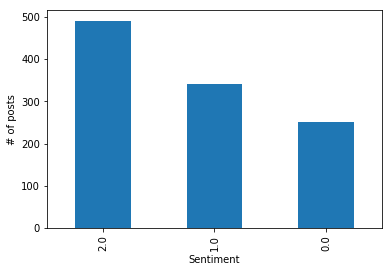

In [16]:
# Distribution of postive, neutral, negative posts from training data
training['Sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('# of posts')
plt.show()

## Preprocessing 

The input for Sentiment Analysis is the Combined Social Data Pickle file. We preprocess the data to extract facebook posts and twitter tweets into separate files so that we can upload them to BigQuery. Please refer to the Google Cloud AutoML documentation link posted above for instructions on uploading data to BigQuery

In [24]:
# Read pickle file into dataframe
full_data = pd.read_pickle('./Data/Output/Combined_Social_Data_Pickle.pkl')

In [25]:
# Function to clean posts. The text of the posts is stored in description field
def cleanPosts(df):
    '''
        Cleans the text of the posts and adds a new column to the dataframe
        that stores the cleaned version of the posts
        
        The input to the function is the dataframe that contains the posts
    '''
    # Replace new lines
    df['Cleaned Post'] = df.description.str.replace('\n','')
    # Replace tab characters
    df['Cleaned Post'] = df['Cleaned Post'].str.replace('\t',' ')
    # Regular expressions to remove hashtags, non alphanumeric characters and multiple spaces
    #df['Cleaned Post'] = df['Cleaned Post'].str.replace(r'#[^\s]+', '')
    #df['Cleaned Post'] = df['Cleaned Post'].str.replace('[^a-zA-Z0-9\s]', '')
    #df['Cleaned Post'] = df['Cleaned Post'].str.replace('[\s+]', ' ')
    
    return df

In [26]:
# Remove uncleaned data field and rename social media handle fields to prevent duplicate field names
full_data = cleanPosts(full_data)
full_data = full_data.drop(['description'], axis=1)
full_data = full_data.rename(columns={"twitter": "twitter_id", "instagram": "instagram_id", "facebook":"facebook_id", "youtube":"youtube_id"})

In [27]:
def prepareFacebookFile(dataframe):
    '''
        Perform additional preprocessing on the data before uploading to
        BigQuery
    '''
    # Filter out facebook posts from entire dataframe
    facebook_posts = dataframe[(dataframe['social_platform'] == 'Facebook') & (dataframe['type_text'] == 1)]
    # Remove NaN and corrupt records
    facebook_posts = facebook_posts[facebook_posts['normalized_social_engagement_score'].notna()]
    facebook_posts = facebook_posts[facebook_posts['Cleaned Post'].notna()]
    facebook_posts['Cleaned Post'] = facebook_posts['Cleaned Post'].apply(lambda x:str(x).strip())
    facebook_posts = facebook_posts[facebook_posts['Cleaned Post'].map(len) > 1]
    facebook_posts = facebook_posts.reset_index(drop=True)
    
    facebook_posts.to_csv('./files/SentimentAnalysis/fb_data.csv', index=False)

In [28]:
# Calling function to create facebook file (to be uploaded to BigQuery)
prepareFacebookFile(full_data)

In [31]:
def prepareTwitterFile(dataframe):
    '''
        Perform additional preprocessing on the data before uploading to
        BigQuery
    '''
    twitter_posts = dataframe[(dataframe['social_platform'] == 'Twitter') & (dataframe['type_text'] == 1)]
    twitter_posts = twitter_posts[twitter_posts['normalized_social_engagement_score'].notna()]
    twitter_posts = twitter_posts[twitter_posts['Cleaned Post'].notna()]
    twitter_posts['Cleaned Post'] = twitter_posts['Cleaned Post'].apply(lambda x:str(x).strip())
    twitter_posts = twitter_posts[twitter_posts['Cleaned Post'].map(len) > 1]
    twitter_posts = twitter_posts.reset_index(drop=True)
    twitter_posts.to_csv('./files/SentimentAnalysis/twitter_data.csv', index=False)

In [32]:
# Calling function to create twitter file (to be uploaded to BigQuery)
prepareTwitterFile(full_data)

## Sentiment Analysis

This part of the code was run on Google Cloud Datalab to speed up processing

In [ ]:
# Facebook

# Imports
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq
from google.cloud import automl_v1beta1
from google.cloud.automl_v1beta1.proto import service_pb2

In [ ]:
# Execute query and store results in dataframe
fb_query = bq.Query('$$BIG QUERY TABLE QUERY')
output_options = bq.QueryOutput.table(use_cache=False)
result = fb_query.execute(output_options=output_options).result()
df_fb = result.to_dataframe()
df_fb['Sentiment Score'] = -100 ## Placeholder

In [ ]:
# Set environment variable
import sys,os,os.path
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='$$CREDENTIALS FILE'

In [ ]:
import sys

from google.cloud import automl_v1beta1
from google.cloud.automl_v1beta1.proto import service_pb2


def get_prediction(body):
    '''
        Method that uses the custom trained model to make prediction
    '''
    prediction_client = automl_v1beta1.PredictionServiceClient()

    name = '$$AUTO ML MODEL NAME'
    payload = {'text_snippet': {'content': body.encode('utf-8'), 'mime_type': 'text/plain' }}
    params = {}
    request = prediction_client.predict(name, payload, params)
    
    return request # waits till request is returned

In [ ]:
# Main block of code that calls the method to make predictions and writes them to output file
import time

start = time.time()

for i in range(df_fb.shape[0]): ##Change the index to what you want to analyze
    if i%100 == 0:
        print('Completed ' + str(i))
       
    try:
        response = get_prediction(df_fb.iat[i,0])
        df_fb['Sentiment Score'][i] = response.payload[0].text_sentiment.sentiment
    except:
        df_fb['Sentiment Score'][i]= -10.0
        pass
    #print (get_prediction(dfbeyonce.iat[i,1]))  
end = time.time()
print(end - start)
df_fb.to_csv('./files/SentimentAnalysis/fb_sentiment_analysis.csv', encoding='utf-8', index=False) 

In [ ]:
# Twitter

#Imports
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq
from google.cloud import automl_v1beta1
from google.cloud.automl_v1beta1.proto import service_pb2

In [ ]:
# Execute query and store results in dataframe
twitter_query = bq.Query('$$BIG QUERY TABLE QUERY')
output_options = bq.QueryOutput.table(use_cache=False)
result = twitter_query.execute(output_options=output_options).result()
df_twitter = result.to_dataframe()
df_twitter['Sentiment Score'] = -100

In [ ]:
import time

start = time.time()

for i in range(df_twitter.shape[0]): 
    ##Change the index to what you want to analyze
    try:
        response = get_prediction(df_twitter.iat[i,0])
        df_twitter['Sentiment Score'][i] = response.payload[0].text_sentiment.sentiment
    except:
        df_twitter['Sentiment Score'][i]= -10.0
        pass
    #print (get_prediction(dfbeyonce.iat[i,1]))  
end = time.time()
print(end - start)
df_twitter.to_csv('./files/SentimentAnalysis/twitter_sentiment_analysis.csv', encoding='utf-8') 

The generated files need to be moved to ./files/SentimentAnalysis/ folder wither by using SFTP or SCP from the Google Compute Instance to local machine

## Analysis

In [33]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [35]:
# Read the twitter and facebook sentiment analysis data files
fb_sentiment_analysis = pd.read_csv('./files/SentimentAnalysis/fb_sentiment_analysis.csv', encoding='utf-8')
fb_sentiment_analysis['platform'] = 'Facebook'
twitter_sentiment_analysis = pd.read_csv('./files/SentimentAnalysis/twitter_sentiment_analysis.csv', encoding='utf-8')
twitter_sentiment_analysis['platform'] = 'Twitter'

# Create a combined file
combined_df = pd.concat([fb_sentiment_analysis, twitter_sentiment_analysis], ignore_index=True)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


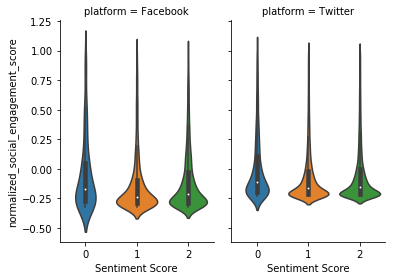

In [58]:
# Plotting social enagagement vs sentiment
sns.catplot(x="Sentiment Score", y="normalized_social_engagement_score",
                col="platform",
                 data=combined_df[combined_df['normalized_social_engagement_score'] < 1], kind="violin", split=True,
                 height=4, aspect=.7);

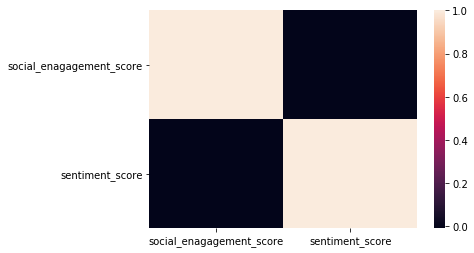

In [53]:
# Check if any correlation between Social Engagement and Sentiment
combined_df_sub = combined_df[['normalized_social_engagement_score', 'Sentiment Score']]
corr = combined_df_sub.corr()
sns.heatmap(corr, 
            xticklabels=['social_enagagement_score','sentiment_score'],
            yticklabels=['social_enagagement_score','sentiment_score'])

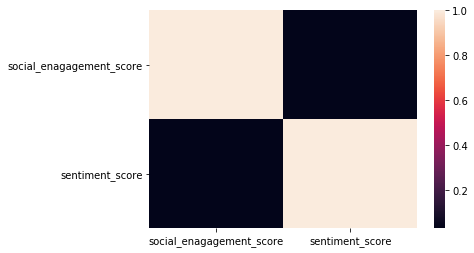

In [56]:
# Check if any correlation between Social Engagement and Sentiment for twitter or facebook
fb_sentiment_analysis_sub = fb_sentiment_analysis[['normalized_social_engagement_score', 'Sentiment Score']]
corr = fb_sentiment_analysis_sub.corr()
sns.heatmap(corr, 
            xticklabels=['social_enagagement_score','sentiment_score'],
            yticklabels=['social_enagagement_score','sentiment_score'])


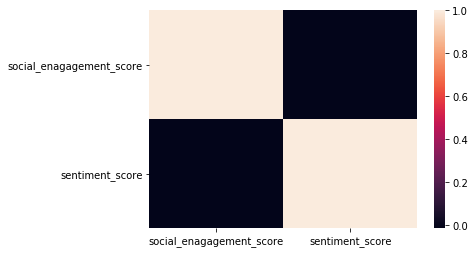

In [57]:
# Twitter
twitter_sentiment_analysis_sub = twitter_sentiment_analysis[['normalized_social_engagement_score', 'Sentiment Score']]
corr = twitter_sentiment_analysis_sub.corr()
sns.heatmap(corr, 
            xticklabels=['social_enagagement_score','sentiment_score'],
            yticklabels=['social_enagagement_score','sentiment_score'])

As there is no significant correlation let us focus on some other aspects

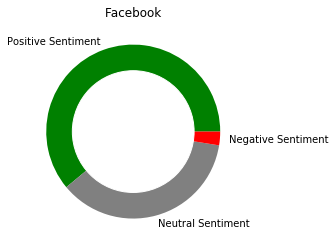

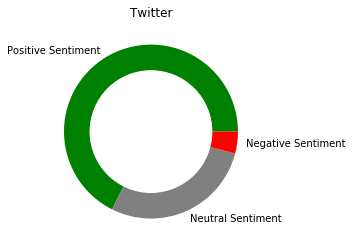

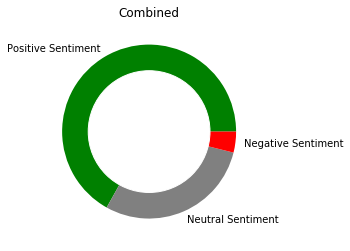

In [63]:
# Compute percentage of postive, neutral vs negative tweets
names='Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment'
size=fb_sentiment_analysis['Sentiment Score'].value_counts(normalize=True).tolist()
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','grey','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Facebook')
plt.show()

names='Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment'
size=twitter_sentiment_analysis['Sentiment Score'].value_counts(normalize=True)
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','grey','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Twitter')
plt.show()

names='Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment'
size=combined_df['Sentiment Score'].value_counts(normalize=True)
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','grey','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Combined')
plt.show()

Analysis of Rock Artists:
Twenty One Pilots, The Neighbourhood, Harry Styles were identified as rock artists with high social engagement scores while Diego Torres was identified as rock artist with lower social engagement score. Let us analyze if we see a pattern in the post sentiments of artists with high social engagement score vs low social engagement score